# Basic Mesh Composition

In [4]:
from dewloosh.mesh.space import CartesianFrame
from dewloosh.mesh.recipes import cylinder
from dewloosh.mesh import PolyData, LineData
from dewloosh.mesh.cells import H8, TET4
from dewloosh.mesh.topo.tr import H8_to_L2, H8_to_TET4
from dewloosh.math.array import minmax
import numpy as np
import pyvista as pv

n_angles = 60
n_radii = 30
min_radius = 5
max_radius = 25
n_z = 20
h = 50
angle=1

shape = (min_radius, max_radius), angle, h
size = n_radii, n_angles, n_z
frame = CartesianFrame(dim=3)
cyl = cylinder(shape, size=10., voxelize=True, frame=frame)

coords = cyl.coords()
topo = cyl.topology()
centers = cyl.centers()

cxmin, cxmax = minmax(centers[:, 0])
czmin, czmax = minmax(centers[:, 2])
cxavg = (cxmin + cxmax)/2
czavg = (czmin + czmax)/2
b_upper = centers[:, 2] > czavg
b_lower = centers[:, 2] <= czavg
b_left = centers[:, 0] < cxavg
b_right = centers[:, 0] >= cxavg
upper = np.where(b_upper)[0]
lower = np.where(b_lower)[0]
left = np.where(b_left)[0]
right = np.where(b_right)[0]
iL2 = np.where(b_upper & b_left)[0]
iTET4 = np.where(b_upper & b_right)[0]
iH8 = np.where(b_lower)[0]
_, topoL2 = H8_to_L2(coords, topo[iL2])
_, topoTET4 = H8_to_TET4(coords, topo[iTET4])
topoH8 = topo[iH8]

mesh = PolyData(coords=coords, frame=frame)

mesh['lines', 'L2'] = LineData(topo=topoL2, frame=frame)
mesh['lines', 'L2'].config['pyvista', 'plot', 'color'] = 'blue'
mesh['lines', 'L2'].config['pyvista', 'plot', 'line_width'] = 1

mesh['bodies', 'TET4'] = PolyData(topo=topoTET4, celltype=TET4, frame=frame)
mesh['bodies', 'TET4'].config['pyvista', 'plot', 'color'] = 'green'
mesh['bodies', 'H8'].config['pyvista', 'plot', 'opacity'] = 0.9

mesh['bodies', 'H8'] = PolyData(topo=topoH8, celltype=H8, frame=frame)
mesh['bodies', 'H8'].config['pyvista', 'plot', 'color'] = 'red'
mesh['bodies', 'H8'].config['pyvista', 'plot', 'show_edges'] = True

plotter = pv.Plotter()
mesh.pvplot(notebook=False, plotter=plotter)
plotter.show(jupyter_backend='none')

In [5]:
mesh.pvplot(notebook=True, jupyter_backend='pythreejs', window_size=(600, 400))

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, 1…

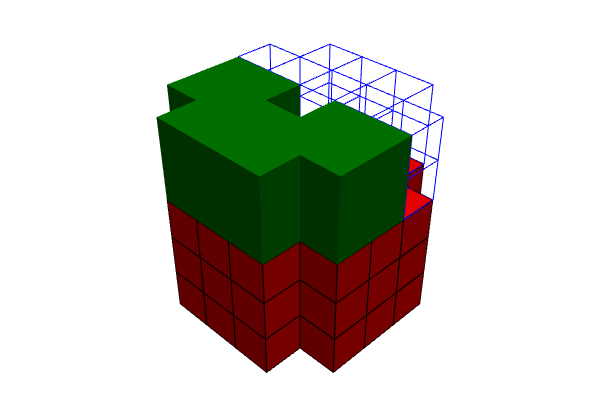

In [6]:
mesh.pvplot(notebook=True, jupyter_backend='static', window_size=(600, 400))